In [30]:
# Install required libraries if not already installed
# !pip install scikit-learn seaborn matplotlib pandas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [31]:
df=pd.read_csv('/content/Loan_default.csv')

/tmp/ipython-input-4155285983.py:1: DtypeWarning: Columns (10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/content/Loan_default.csv')


In [32]:
# Drop LoanID (not useful) and rows with missing target
df = df.drop(columns=["LoanID"])

In [33]:
# Handle categorical features (Label Encoding)
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [34]:
# Drop rows with missing values in features
df = df.dropna()

In [35]:
# Features and target
X = df.drop(columns=["Default"])
y = df["Default"]

In [36]:
# Feature Scaling
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
# Feature Selection (L1 penalty)
# ===============================
lr_selector = LogisticRegression(penalty="l1", solver="liblinear", random_state=42)
lr_selector.fit(X_scaled, y)

feature_importance = pd.Series(lr_selector.coef_[0], index=X.columns)
important_features = feature_importance[feature_importance != 0].index.tolist()

print("Important Features Selected:\n", important_features)


Important Features Selected:
 ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']


In [38]:
# Reduce dataset to important features
X_selected = df[important_features]
X_selected_scaled = scaler.fit_transform(X_selected)

In [39]:
# Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_scaled, y, test_size=0.3, random_state=42
)

In [40]:
# Logistic Regression Model
# ===============================
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# ===============================
# Evaluation
# ===============================
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     14402
         1.0       0.62      0.03      0.06      1857

    accuracy                           0.89     16259
   macro avg       0.75      0.51      0.50     16259
weighted avg       0.86      0.89      0.84     16259



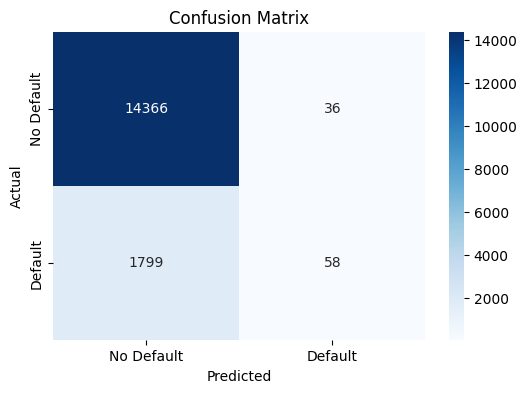

In [41]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Default","Default"],
            yticklabels=["No Default","Default"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

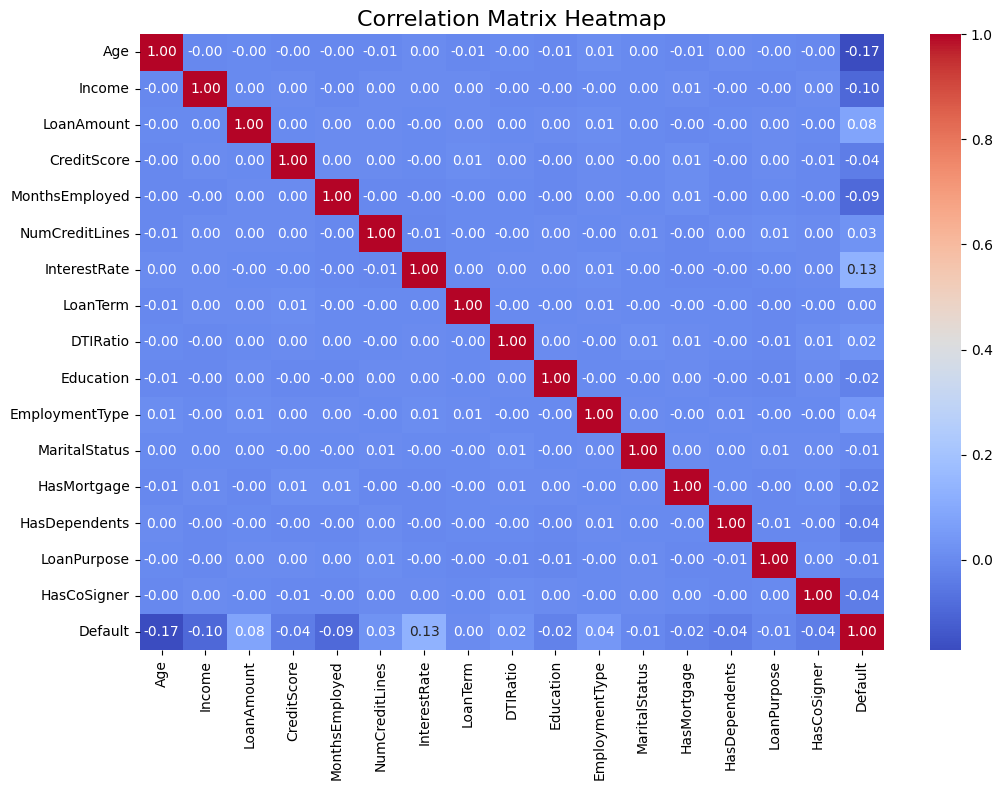


Correlation with Default column:
Default           1.000000
InterestRate      0.132196
LoanAmount        0.080667
EmploymentType    0.039042
NumCreditLines    0.027403
DTIRatio          0.022917
LoanTerm          0.002767
MaritalStatus    -0.006187
LoanPurpose      -0.008085
Education        -0.022737
HasMortgage      -0.022913
CreditScore      -0.035349
HasCoSigner      -0.036750
HasDependents    -0.038743
MonthsEmployed   -0.094214
Income           -0.098188
Age              -0.172244
Name: Default, dtype: float64


In [42]:
# Correlation matrix
plt.figure(figsize=(12,8))
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()

# Show correlation of features with target (Default) separately
print("\nCorrelation with Default column:")
print(corr_matrix["Default"].sort_values(ascending=False))

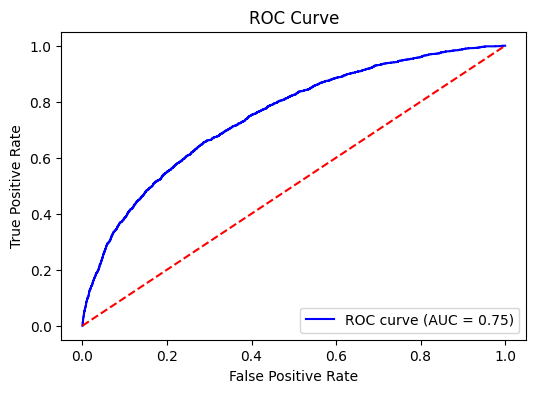

In [43]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

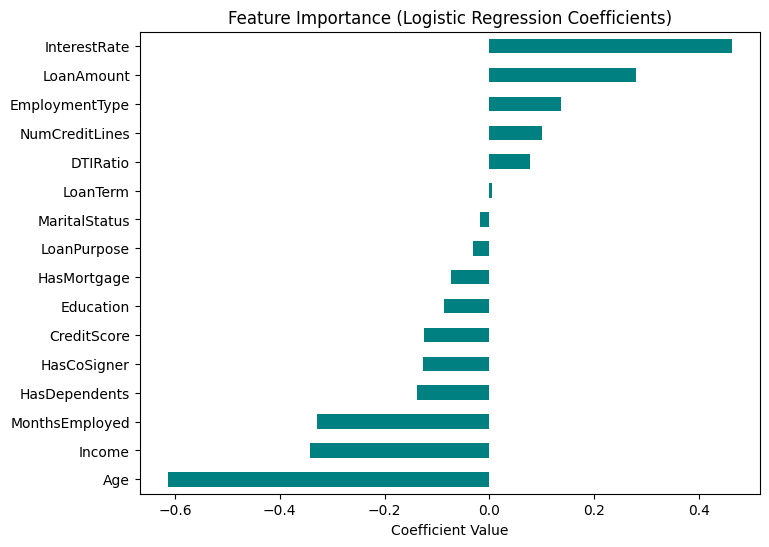

In [44]:
# Feature Importance
plt.figure(figsize=(8,6))
feature_importance[important_features].sort_values().plot(kind="barh", color="teal")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.show()

In [45]:
from sklearn.metrics import accuracy_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.8871


In [46]:
# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.8871


EQUATION

In [47]:
# Intercept and coefficients
intercept = model.intercept_[0]
coefficients = model.coef_[0]

# Match coefficients to feature names
equation = pd.DataFrame({
    "Feature": important_features,
    "Coefficient": coefficients
})

print("Intercept (β0):", intercept)
print("\nLogistic Regression Equation:")
equation_str = "logit(p) = {:.4f}".format(intercept)
for feat, coef in zip(important_features, coefficients):
    equation_str += " + ({:.4f} * {})".format(coef, feat)

print(equation_str)

Intercept (β0): -2.3446764974573964

Logistic Regression Equation:
logit(p) = -2.3447 + (-0.6121 * Age) + (-0.3311 * Income) + (0.2730 * LoanAmount) + (-0.1161 * CreditScore) + (-0.3320 * MonthsEmployed) + (0.0940 * NumCreditLines) + (0.4515 * InterestRate) + (0.0122 * LoanTerm) + (0.0747 * DTIRatio) + (-0.0883 * Education) + (0.1292 * EmploymentType) + (-0.0034 * MaritalStatus) + (-0.0690 * HasMortgage) + (-0.1285 * HasDependents) + (-0.0472 * LoanPurpose) + (-0.1180 * HasCoSigner)


In [48]:
import statsmodels.api as sm

# Features (all columns except target)
X_all = df.drop(columns=["Default"])
y_all = df["Default"]

# Add constant (intercept term)
X_all_const = sm.add_constant(X_all)

# Logistic regression using statsmodels
logit_model = sm.Logit(y_all, X_all_const)
result = logit_model.fit()

# Summary with coefficients, standard errors, z-scores, and p-values
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.318135
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                54194
Model:                          Logit   Df Residuals:                    54177
Method:                           MLE   Df Model:                           16
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                  0.1184
Time:                        07:18:11   Log-Likelihood:                -17241.
converged:                       True   LL-Null:                       -19557.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.3500      0.109     -3.199      0.001      -0.564      -0.136
Age              

PRED


In [49]:
import pandas as pd

# Convert Excel to CSV (run only once)
df_excel = pd.read_excel("/content/Pred123.xlsx")
df_excel.to_csv("/content/Pred123.csv", index=False)


In [50]:
import pandas as pd

# Load new dataset (CSV version of Pred123.xlsx)
df_new = pd.read_csv("/content/Pred123.csv")

# Drop LoanID (not used in training), skip others since already removed
df_new = df_new.drop(columns=["LoanID"], errors="ignore")

# Encode categorical variables (same encoding as training)
for col in categorical_cols:
    if col in df_new.columns:
        df_new[col] = le.fit_transform(df_new[col].astype(str))

# Align features with training set (important: only the ones used in model)
df_new = df_new.reindex(columns=important_features, fill_value=0)

# Scale features with training scaler
df_new_scaled = scaler.transform(df_new)

# Predict default probability and class
df_new["Default_Prob"] = model.predict_proba(df_new_scaled)[:, 1]
df_new["Default_Predicted"] = model.predict(df_new_scaled)

print(df_new[["Default_Prob", "Default_Predicted"]])


   Default_Prob  Default_Predicted
0      0.272162                0.0
1      0.152755                0.0
2      0.174887                0.0


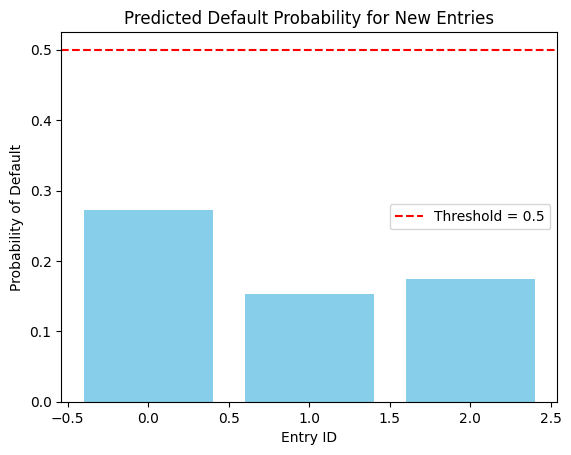

In [54]:
import matplotlib.pyplot as plt

plt.bar(df_new.index, df_new["Default_Prob"], color="skyblue")
plt.axhline(0.5, color="red", linestyle="--", label="Threshold = 0.5")
plt.xlabel("Entry ID")
plt.ylabel("Probability of Default")
plt.title("Predicted Default Probability for New Entries")
plt.legend()
plt.show()
